## Simple Lane Detection Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import Libraries

In [ ]:
!git clone https://github.com/Mayar-ElMallah/Perception-Stack-for-Self-Driving-Cars.git
%cd Perception-Stack-for-Self-Driving-Cars/
import numpy as np
import pandas as pd
import cv2
import distutils

import os
import glob
import matplotlib.pyplot as plt
import pickle
from skimage import measure
import numpy as np
import cv2
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from queue import Queue
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Cloning into 'Perception-Stack-for-Self-Driving-Cars'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 159 (delta 17), reused 5 (delta 5), pack-reused 124
Receiving objects: 100% (159/159), 78.62 MiB | 18.06 MiB/s, done.
Resolving deltas: 100% (49/49), done.
/content/Perception-Stack-for-Self-Driving-Cars
Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2088960/45929032 bytes (4.5%)3825664/45929032 bytes (8.3%)5677056/45929032 bytes (12.4%)8216576/45929032 bytes (17.9%)10633216/45929032 bytes (23.2%)11993088/45929032 bytes (26

# Construct array of images

In [ ]:
image_test1= plt.imread("./test_images/straight_lines1.jpg")
image_test2= plt.imread("./test_images/test1.jpg")
image_test3= plt.imread("./test_images/test4.jpg")
image_test4= plt.imread("./test_images/test6.jpg")
image_test5= plt.imread("./test_images/test2.jpg")
image_test6= plt.imread("./test_images/test3.jpg")
image_test7= plt.imread("./test_images/test5.jpg")


test_images=[image_test1,image_test2,image_test3,image_test4,image_test5,image_test6,image_test7]

# Calibration & Distortion Correction

# Why is the checkerboard pattern so widely used in calibration?

Checkerboard patterns are distinct and easy to detect in an image. Not only that, the corners of squares on the checkerboard are ideal for localizing them because they have sharp gradients in two directions. In addition, these corners are also related by the fact that they are at the intersection of checkerboard lines. All these facts are used to robustly locate the corners of the squares in a checkerboard pattern. 

In [ ]:
def undistort_img():
    
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    # Prepare object points 0,0,0 ... 8,5,0
    #Calibration Boards-> Opencv 9 × 6 asymmetric checkerboard
    obj_pts = np.zeros((6*9,3), np.float32)
    #To initialize 2D array 
    obj_pts[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Creating vector to store vectors of 3D points for each checkerboard image
    objpoints = []
    # Creating vector to store vectors of 2D points for each checkerboard image
    imgpoints = []

    # Get directory recursively for all calibration images
    images = glob.glob('camera_cal/*.jpg')

    for indx, fname in enumerate(images):
        img = cv2.imread(fname)
        #Gray scale conversion
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        #Find 2D coordinates of checkerboard
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        
        ## If desired number of corners are found in the image then ret = true, add object points, image points 
        if ret == True:
            objpoints.append(obj_pts)    # Certainly, every loop objp is the same, in 3D.
            
            #refine the pixel coordinates to increase the precision
            corners2 = cv2.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)
            imgpoints.append(corners)


    # Test undistortion on img
    img_size = (img.shape[1], img.shape[0])

    """
    Performing camera calibration by
    passing the value of known 3D points (objpoints)
    and corresponding pixel coordinates of the
    detected corners (imgpoints)
    """
    ret, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)

    #dst = cv2.undistort(img, cameraMatrix, distCoeffs, None, cameraMatrix)
    # Save camera calibration for later use
    dist_pickle = {}
    dist_pickle['mtx'] = cameraMatrix
    dist_pickle['dist'] = distCoeffs
    #storing the image
    pickle.dump( dist_pickle, open('camera_cal/cal_pickle.p', 'wb') )

In [ ]:
def undistort(img, cal_dir='camera_cal/cal_pickle.p'):
    #cv2.imwrite('camera_cal/test_cal.jpg', dst)
    with open(cal_dir, mode='rb') as f:
        file = pickle.load(f)
    mtx = file['mtx']
    dist = file['dist']
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return dst

In [ ]:
undistort_img()

Text(0.5, 1.0, 'Undistorted Image')

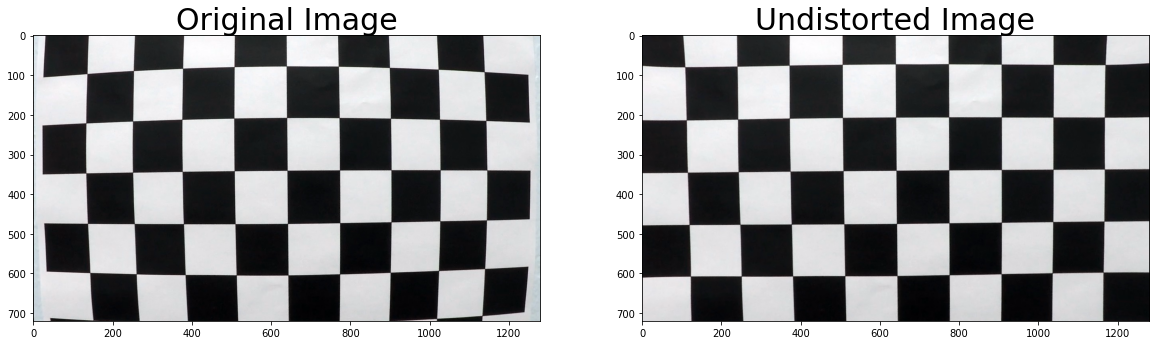

In [ ]:
img = cv2.imread('camera_cal/calibration1.jpg')
dst = undistort(img)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

Distortion correction on test images


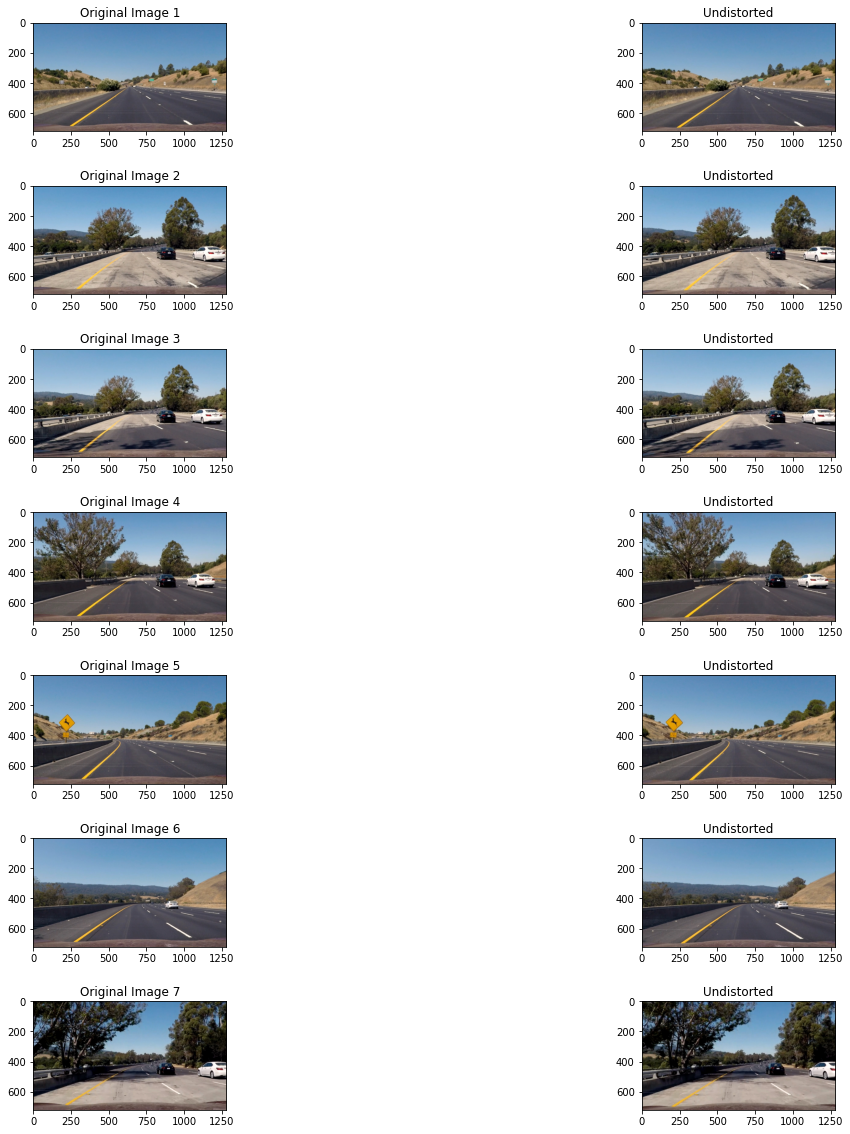

In [ ]:

row=0

f,axes= plt.subplots(len(test_images),2, figsize=(20,20))
f.subplots_adjust(hspace=0.5)
print("Distortion correction on test images")

for image in test_images:
    #image= cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    y=image.shape[0]
    x=image.shape[1]
    axes[row,0].set_title('Original Image '+str(row+1))
    axes[row,0].imshow(image)
    undistorted_image= undistort(image)
    axes[row,1].imshow(undistorted_image)
    axes[row,1].set_title('Undistorted')
    row+=1

## HLS Functions

In [ ]:
'''define function to convert color spase from RGB to HSL
    Goal: adapt sunlight effect'''
def CVt2hls(img):
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    h=hls[:,:,0]
    l=hls[:,:,1]
    s=hls[:,:,2]
    return h,l,s

'''define function to show different hsl channel for image 
    Goal: Figure out which channel is the best for edge detections'''
def tstHLS(test_images):
    row=0
    f,axes= plt.subplots(7,3, figsize=(20,20))
    f.subplots_adjust(hspace=0.5)
    for i in range(0,len(test_images)):
        img=test_images[i]
        h,l,s=CVt2hls(img)
        axes[row,0].imshow(h,cmap="gray")
        axes[row,0].set_title("H channel of test image "+str(i+1))
        axes[row,1].imshow(l,cmap="gray")
        axes[row,1].set_title("l channel of test image "+str(i+1))
        axes[row,2].imshow(s,cmap="gray")
        axes[row,2].set_title("s channel of test image "+str(i+1))
        row=row+1

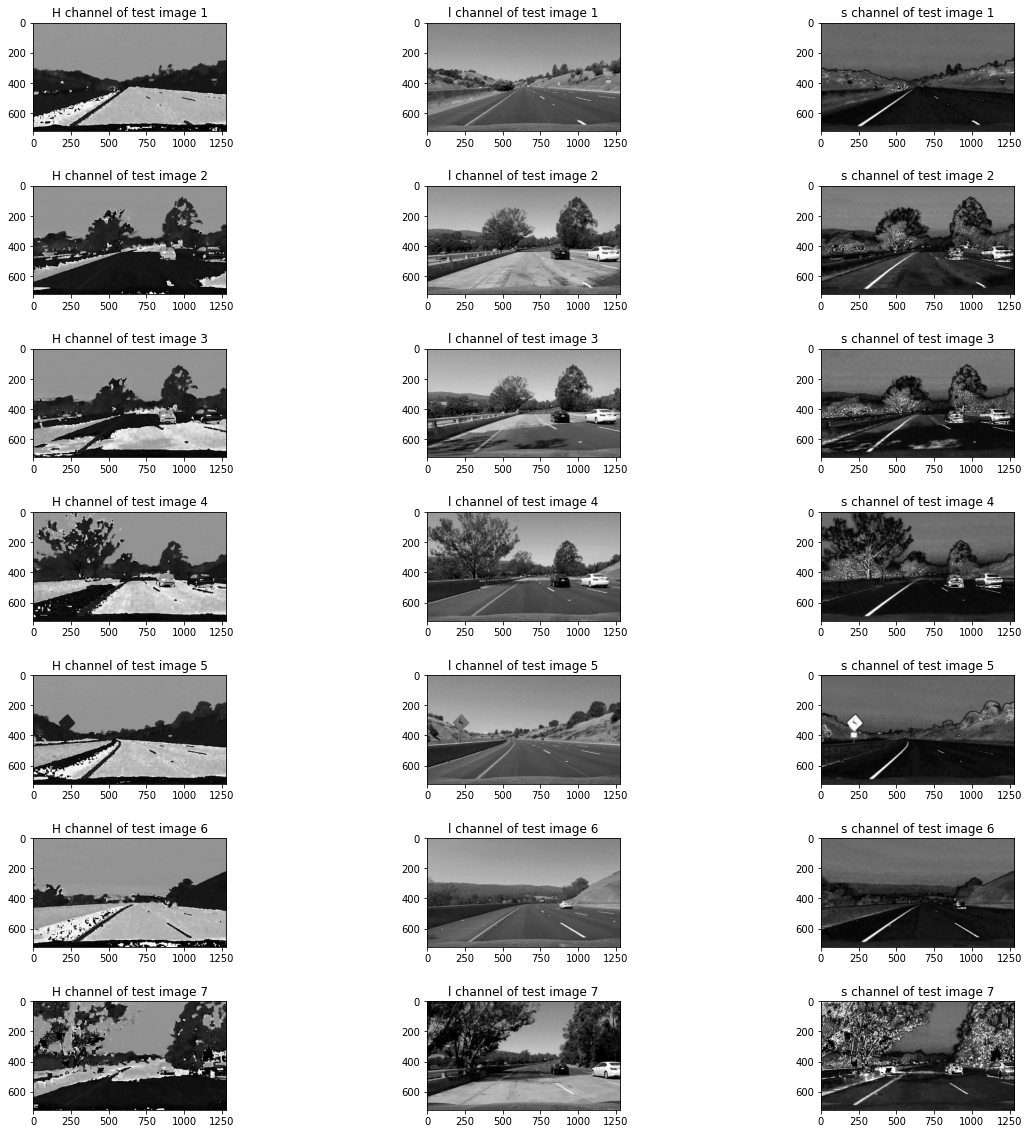

In [ ]:
'''testing the array of images'''
tstHLS(test_images)

S channel is the best for edge detection for every image in testing images

# Prespective Transformation Functions

In [ ]:
'''function to get the matrix which will multiply to transform our images to bird eye view 
the goal of this step is getting rid of the lane curvature '''
def PerspectiveTransform(Src,Dst):
    M=cv2.getPerspectiveTransform(Src,Dst)
    Minv=cv2.getPerspectiveTransform(Dst,Src)
    return M,Minv
'''function to transform our images with multipling by the transformation matrix (M)  '''
'''INTER_LINEAR parameter refers to the method which resize the output by it with reect to the input image 
    this method depends on 2×2 neighboring pixels to get the weighted average for the interpolated pixel'''
def WarpImg (img,M):
    dsize=(img.shape[1],img.shape[0])
    return cv2.warpPerspective(img, M,(1280,720),cv2.INTER_LINEAR)


def reverse_warping(img,Minv):
    img_size = (img.shape[1], img.shape[0])
    unwarped= cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return unwarped


In [ ]:
'''Now we need to determine the corners of the lane in input image and their coordinates in the output 
    GOAL is getting a bird eye view of lane and look like something like a rectangle'''

'''
src=np.float32([[300,700],[1075,700],[750,450],[620,450]])
dst=np.float32([[190,700],[1075,700],[1000,0],[200,0]])
-----------------------------------------------------------
src=np.float32([[200,700],[1200,700],[700,450],[595,450]])
dst=np.float32([[200,700],[1000,700],[700,450],[200,0]])'''

'''
by try and error we conclude somethings we should put them in consideration such the ratio of the offset 
for each point with respect to the size image'''
'''And by trying different values of offset we find that offset=200 is good'''    


offset=200
height, width= image_test1.shape[0],image_test1.shape[1]
src=np.float32([(595,450),(700,450),(1200,700),(200,700)])
dst=np.float32([(offset,0),(width-offset,0),(width-offset,height),(offset,height)])



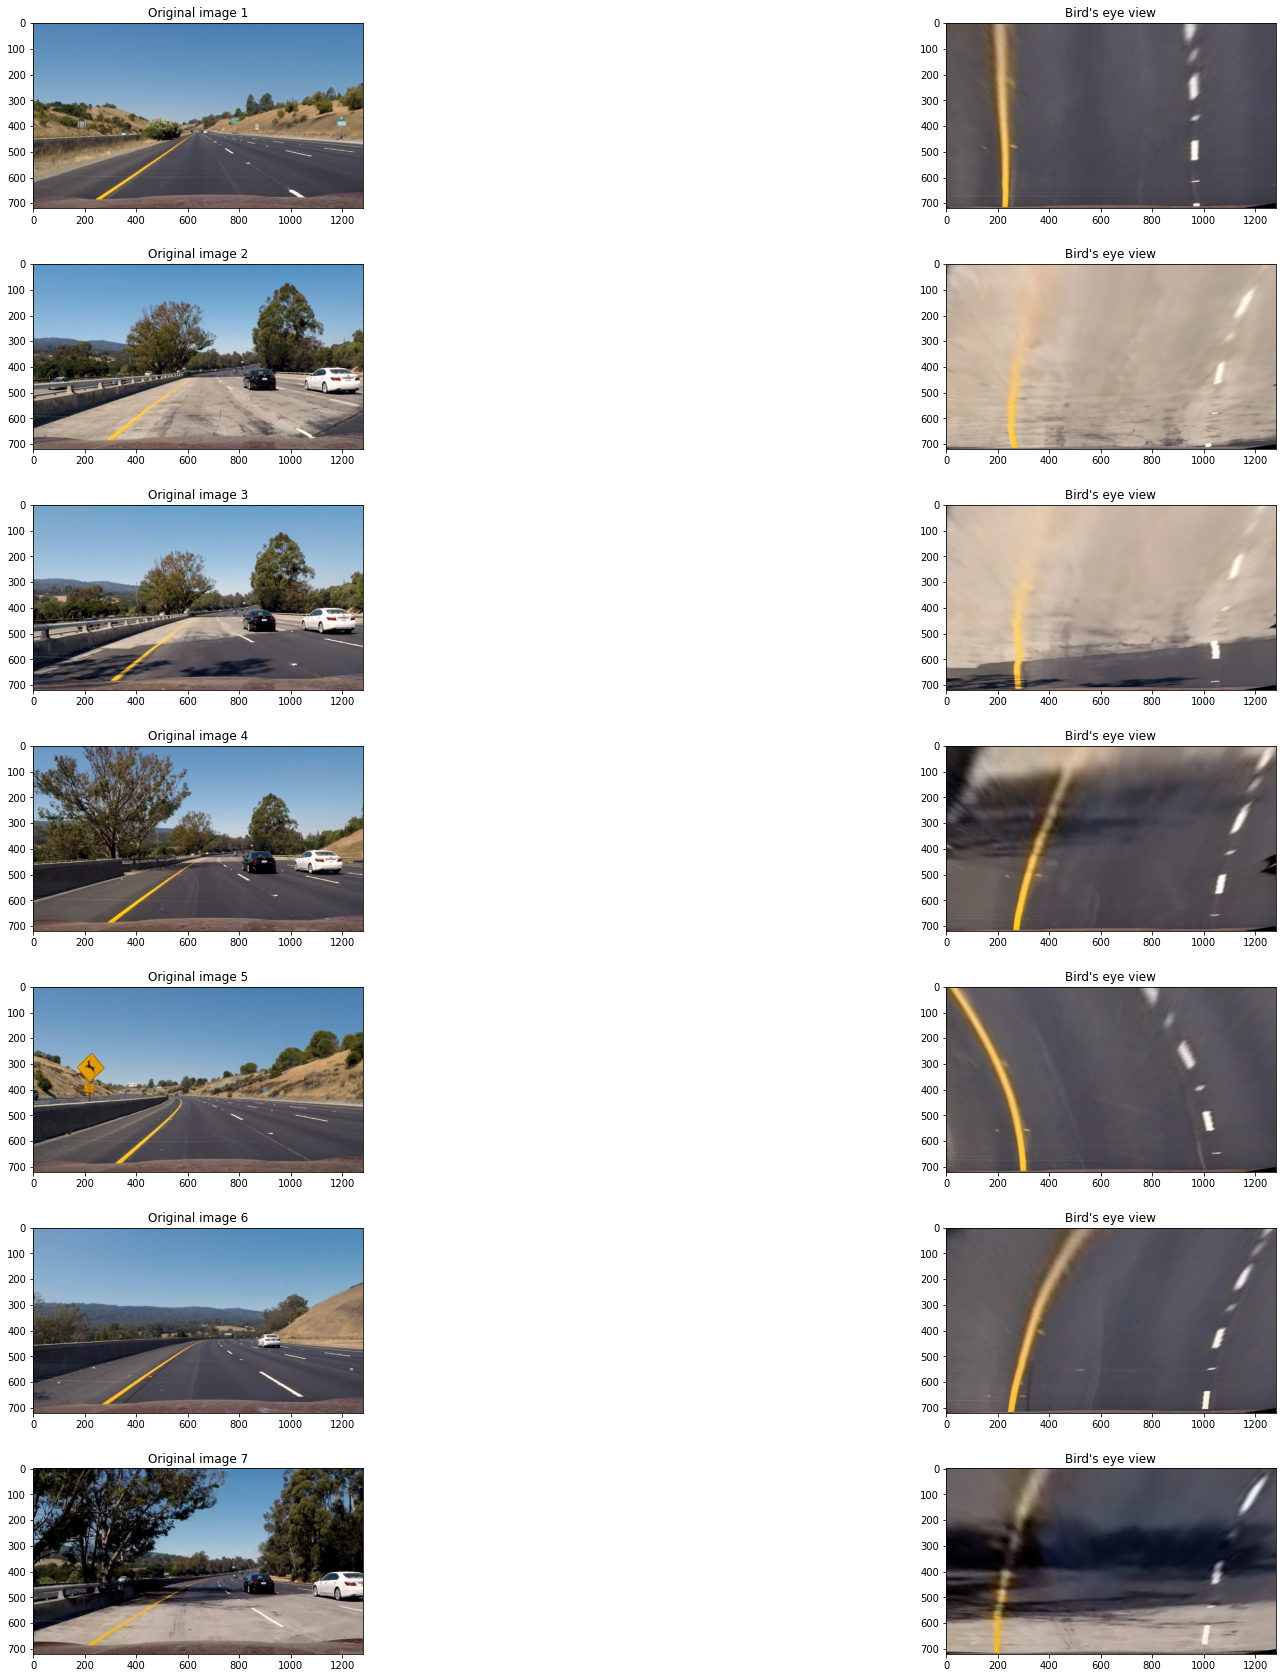

In [ ]:
'''creating numpy array of output images and show them'''
Unwarped_images=[]
f,axes= plt.subplots(len(test_images),2, figsize=(30,30))
f.subplots_adjust(hspace=0.3)
row=0
for image in test_images :
    mat,inv=PerspectiveTransform(src,dst)
    unwarped_image= WarpImg(image,mat)
    Unwarped_images.append(unwarped_image)
    y=image.shape[0]
    x=image.shape[1]
    axes[row,0].imshow(image)
    axes[row,0].set_title('Original image '+str(row+1))
    axes[row,1].imshow(unwarped_image)
    axes[row,1].set_title("Bird's eye view")
    row+=1   

# Sobel Filtering

### It is one of the main factors that can detect the lines of the lane especially, if they are colored.
### Lane lines typically have a high contrast to the road, so we can use this to our advantage.
We'll still be using the HLS Colorspace again, this time to detect changes in Saturation and Lightness. The sobel operators are applied to these two channels, and we extract the gradient with respect to the x axis, and add the pixels which pass our gradient threshold to a binary matrix representing the pixels in our image.


## Sobel X,Y

In [ ]:
def sobel_image(img, orient='x',thresh_min=0, thresh_max=255, convert=True):
    
    
    gray= img
    if(convert):
        gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobel=None
    
    #we're interested mainly on vertical lines
    if(orient=='x'):
        #To calculate the gradient in x direction so the filter has the -ve numbers on the left col
        # The depth of the output image is cv2.CV_64F to get 2D Floated Matrix
        #By default the kernel size is 3x3
        sobel= cv2.Sobel(gray, cv2.CV_64F, 1,0,ksize=3)
    else:
        #To calculate the gradient in y direction so the filter has the -ve numbers on the bottom row
        sobel= cv2.Sobel(gray, cv2.CV_64F, 0,1,ksize=sobel_kernel)
    
    #Scaling
    sobel_abs= np.absolute(sobel) # Absolute x/y derivative to accentuate lines away from horizontal/vertical
    #to get the range from 0 to 255
    sobel_8bit= np.uint8(255* sobel_abs/np.max(sobel_abs))
    binary_output= np.zeros_like(sobel_8bit) 
    binary_output[(sobel_8bit>=thresh_min) & (thresh_max>=sobel_8bit)]=1
    
    return binary_output

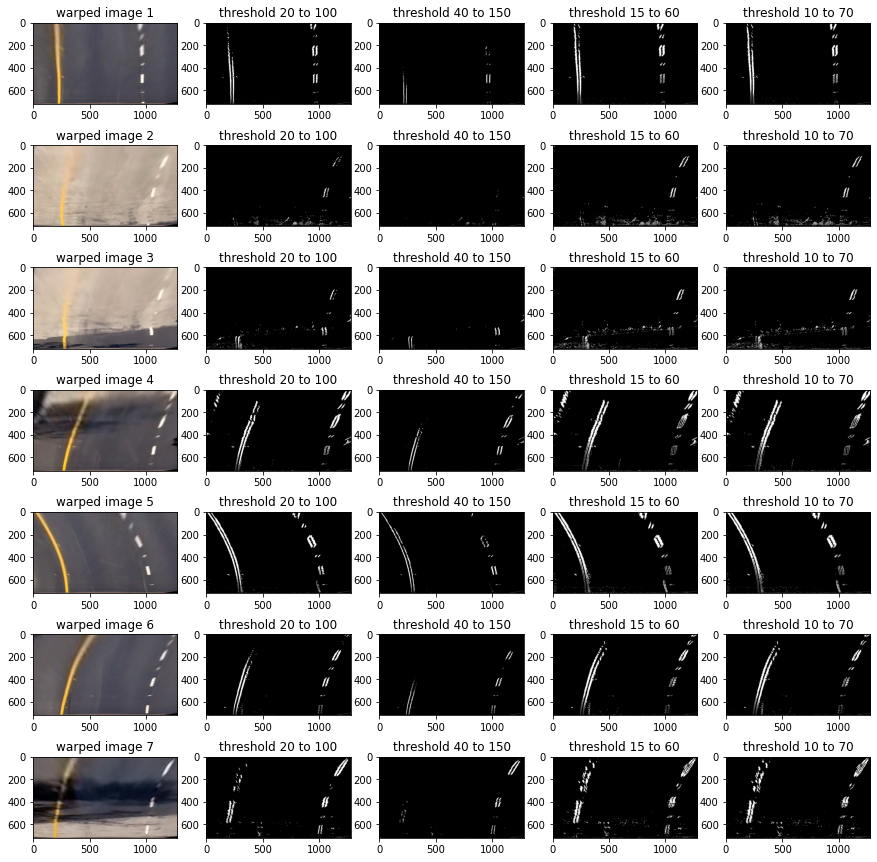

In [ ]:
threshVal= [(20,100),(40,150),(15,60),(10,70)]
#Unwrap folder of eyebirds images
f,axes= plt.subplots(len(Unwarped_images),5, figsize=(15,15))
# hspace = the amount of height reserved for space between subplots
f.subplots_adjust(hspace =0.5)
row=0

for image in Unwarped_images:
    
    axes[row,0].imshow(image)
    axes[row,0].set_title('warped image '+str(row+1))
    #image= cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
    
    sobel_applied_image1= sobel_image(image, 'x', threshVal[0][0], threshVal[0][1], True)
    axes[row,1].imshow(sobel_applied_image1,cmap='gray')
    axes[row,1].set_title('threshold '+str(threshVal[0][0])+' to '+str(threshVal[0][1]))
    
    sobel_applied_image2= sobel_image(image, 'x', threshVal[1][0], threshVal[1][1], True)
    axes[row,2].imshow(sobel_applied_image2,cmap='gray')
    axes[row,2].set_title('threshold '+str(threshVal[1][0])+' to '+str(threshVal[1][1]))
    
    sobel_applied_image3= sobel_image(image, 'x', threshVal[2][0], threshVal[2][1], True)
    axes[row,3].imshow(sobel_applied_image3,cmap='gray')
    axes[row,3].set_title('threshold '+str(threshVal[2][0])+' to '+str(threshVal[2][1]))
    
    sobel_applied_image4= sobel_image(image, 'x', threshVal[3][0], threshVal[3][1], True)
    axes[row,4].imshow(sobel_applied_image3,cmap='gray')
    axes[row,4].set_title('threshold '+str(threshVal[3][0])+' to '+str(threshVal[3][1]))
    
    row+=1

In image 2 and 3, the left lane line is completely getting misidentified. Sobel is identifying road edge as the lane line. This is due to the low contrast between lane line and the bright road in these two images.

## Sobel Magnithude

In [ ]:
def sobel_mag(img, thresh, convert=True):
    gray= img
    if(convert):
        gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx= cv2.Sobel(gray, cv2.CV_64F, 1,0)
    sobely= cv2.Sobel(gray, cv2.CV_64F, 0,1)
    
    mag= (sobelx**2+ sobely**2)**(0.5)
    
    #Scaling
    sobel_mag_8bit= np.uint8(255* mag/np.max(mag))
    binary_output= np.zeros_like(sobel_mag_8bit) 
    binary_output[(sobel_mag_8bit>=thresh[0]) & (thresh[1]>=sobel_mag_8bit)]=1
    
    return binary_output

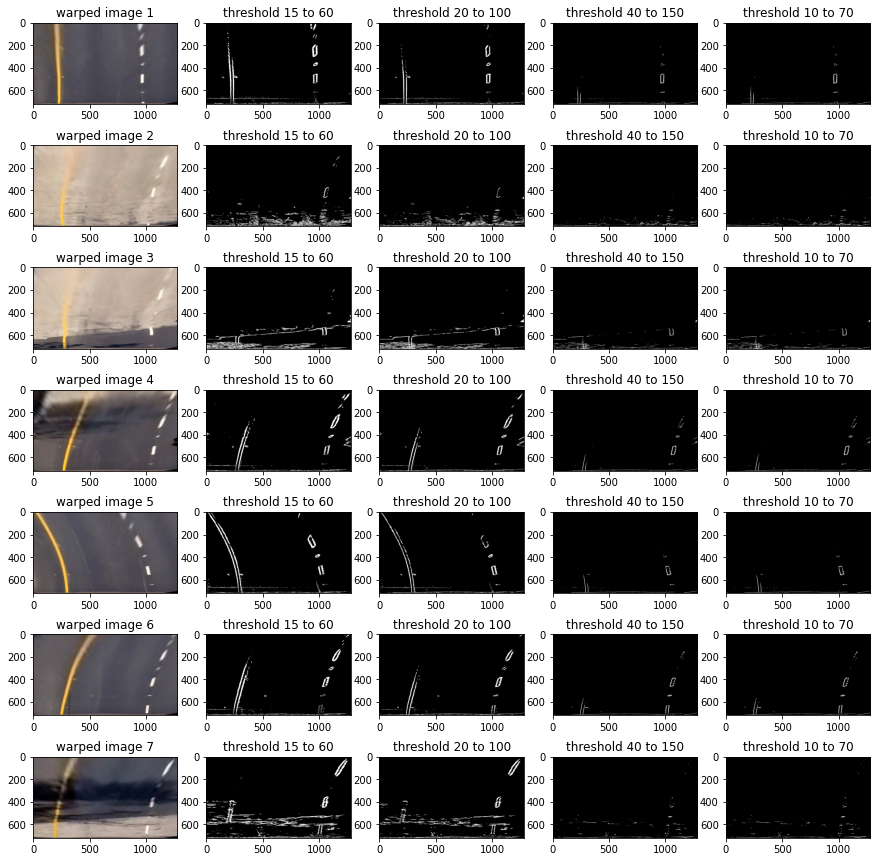

In [ ]:
threshMag= [(15,60),(20,100),(40,150),(10,70)]

f,axes= plt.subplots(len(Unwarped_images),5, figsize=(15,15))
f.subplots_adjust(hspace =0.5)
row=0
convert=True
for image in Unwarped_images:
    
    axes[row,0].imshow(image)
    axes[row,0].set_title('warped image '+str(row+1))
#     convert=False
#     image= cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
    
    sobel_applied_image1= sobel_mag(image, threshMag[0],convert)
    axes[row,1].imshow(sobel_applied_image1,cmap='gray')
    axes[row,1].set_title('threshold '+str(threshMag[0][0])+' to '+str(threshMag[0][1]))
    
    sobel_applied_image2= sobel_mag(image,  threshMag[1],convert)
    axes[row,2].imshow(sobel_applied_image2,cmap='gray')
    axes[row,2].set_title('threshold '+str(threshMag[1][0])+' to '+str(threshMag[1][1]))
    
    sobel_applied_image3= sobel_mag(image,  threshMag[2],convert)
    axes[row,3].imshow(sobel_applied_image3,cmap='gray')
    axes[row,3].set_title('threshold '+str(threshMag[2][0])+' to '+str(threshMag[2][1]))
    
    sobel_applied_image4= sobel_mag(image,  threshMag[3],convert)
    axes[row,4].imshow(sobel_applied_image3,cmap='gray')
    axes[row,4].set_title('threshold '+str(threshVal[3][0])+' to '+str(threshVal[3][1]))
    
    row+=1

I can't see any improvement in lane detection using sobel magnitude also. Sobel is not able to detect low contrast lane lines and hence will completely fail in bright road conditions.

## Sobel Gradient

In [ ]:
def sobel_gradient_image(img, thresh=(0, np.pi/2), convert=True):
    gray= img
    if(convert):
        gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx= cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=15)
    sobely= cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=15)
    
    
    abs_sobelx= np.absolute(sobelx)  # Absolute x derivative to accentuate lines away from horizontal
    abs_sobely= np.absolute(sobely)  # Absolute y derivative to accentuate lines away from vertical
    
    #arctant(filter on y/filter on x)
    grad= np.arctan2(abs_sobely, abs_sobelx)
    
    binary_output=np.zeros_like(grad)
    binary_output[(grad>thresh[0])&(grad<thresh[1])]=1
    return binary_output

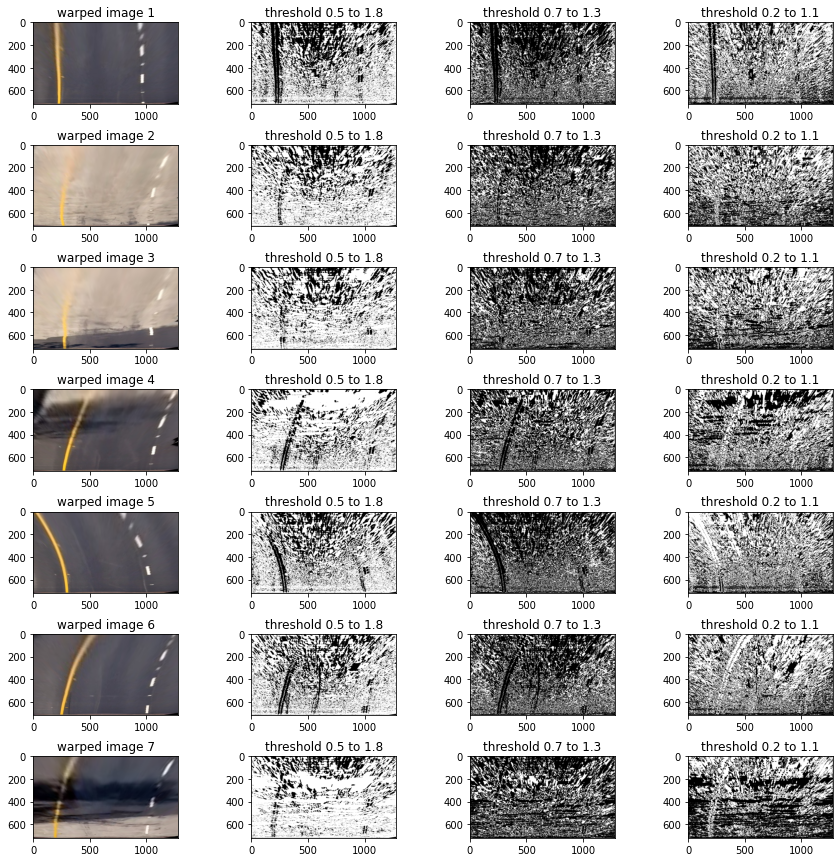

In [ ]:
threshGrad= [(0.5,1.8),(0.7,1.3),(0.2,1.1)]

f,axes= plt.subplots(len(Unwarped_images),4, figsize=(15,15))
f.subplots_adjust(hspace =0.5)
row=0
convert=True
for image in Unwarped_images:
    
    axes[row,0].imshow(image)
    axes[row,0].set_title('warped image '+str(row+1))
#     image= cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
#     convert=False
    
    sobel_applied_image1= sobel_gradient_image(image, threshGrad[0], convert)
    axes[row,1].imshow(sobel_applied_image1,cmap='gray')
    axes[row,1].set_title('threshold '+str(threshGrad[0][0])+' to '+str(threshGrad[0][1]))
    
    sobel_applied_image2= sobel_gradient_image(image,  threshGrad[1], convert)
    axes[row,2].imshow(sobel_applied_image2,cmap='gray')
    axes[row,2].set_title('threshold '+str(threshGrad[1][0])+' to '+str(threshGrad[1][1]))
    
    sobel_applied_image3= sobel_gradient_image(image,  threshGrad[2], convert)
    axes[row,3].imshow(sobel_applied_image3,cmap='gray')
    axes[row,3].set_title('threshold '+str(threshGrad[2][0])+' to '+str(threshGrad[2][1]))
    
    row+=1

Gradient sobel in itself doesn't looks good enough to detect lane lines. Also there is lot of noise in the images. I'll further try to combine the sobel techniques along with the color channels to detect lane lines better and to suppress the detection of road edges in bright as well as dark conditions.

## Combining Sobel with appropriate channels

In [ ]:
#Apply the sobel on L-Channel and do the threshold on S_channel
def Combined(img, s_thresh=(100, 255), sx_thresh=(15, 255)):

    # Convert to HLS color space and separate the V channel
    h_channel,l_channel,s_channel=CVt2hls(img)
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 1) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

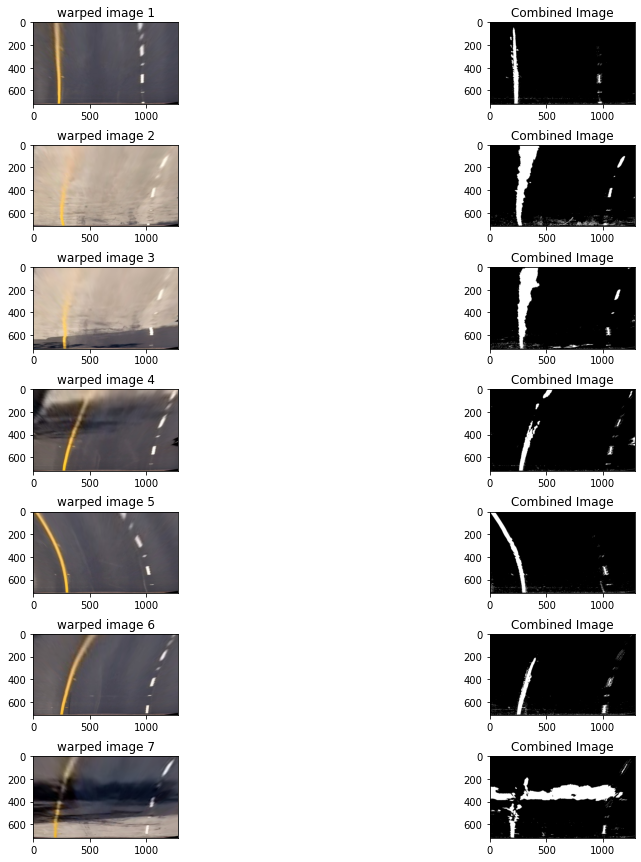

In [ ]:
f,axes= plt.subplots(len(Unwarped_images),2, figsize=(15,15))
f.subplots_adjust(hspace =0.5)
row=0
convert=True
for image in Unwarped_images:
    
    axes[row,0].imshow(image)
    axes[row,0].set_title('warped image '+str(row+1))
#     image= cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
#     convert=False
    
    combined_applied_image1= Combined(image)
    axes[row,1].imshow(combined_applied_image1,cmap='gray')
    axes[row,1].set_title("Combined Image")
    
    row+=1

The last image will be effected by the shadow so we will try different approach

### Experimenting with selected color channels (Y,Cr,L and S)

The value of Y channel is between 16 and 234. Cr has values in interval of 16 to 240...Both increase the intensity of nonBlack region 

In [ ]:

def channelwise_thresholding(image,thresh):
    image = image*(255/np.max(image))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(image)
    binary_output[(image > thresh[0]) & (image <= thresh[1])] = 1
    return binary_output



In [ ]:
def Custom_channel_converter(img):
    
    img1=cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)[:,:,0] # Y channel
    img2=cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)[:,:,1] #Cr channel
    img3=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)[:,:,1] #L channel
    img4=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)[:,:,2] #S channel
    return img1, img2, img3, img4

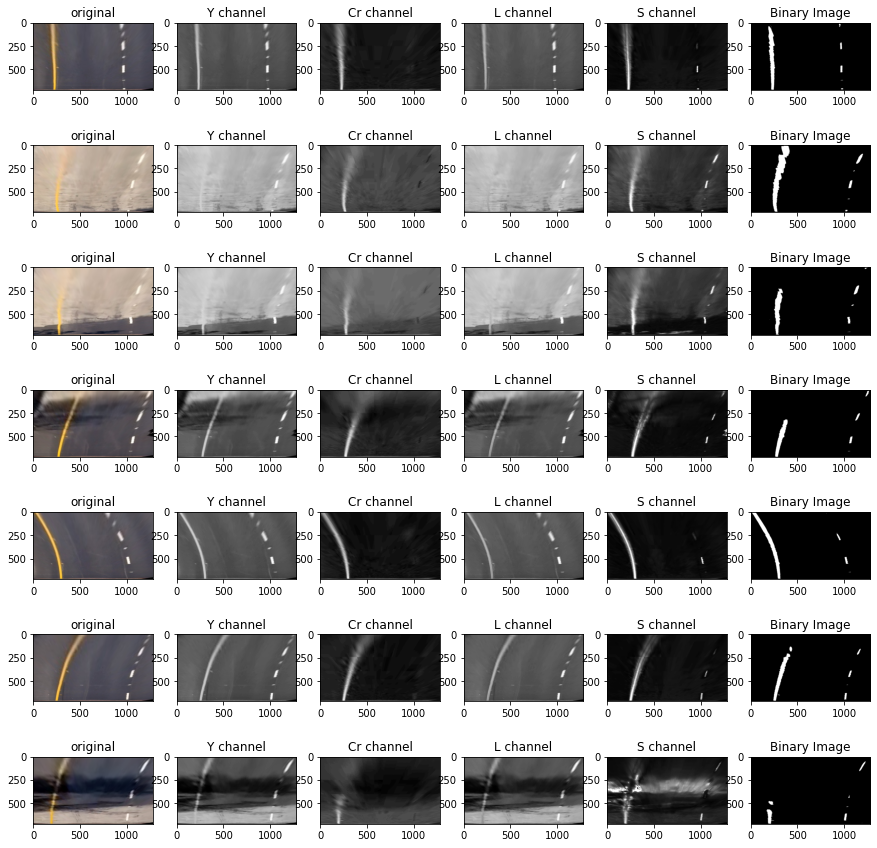

In [ ]:
f,axes= plt.subplots(len(Unwarped_images),6, figsize=(15,15))
f.subplots_adjust(hspace =0.5)
row=0
Processed_Image=[]

for image in Unwarped_images:
    imgY, imgCr, imgL, imgS= Custom_channel_converter(image)
    axes[row,0].imshow(image)
    axes[row,0].set_title('original')
    axes[row,1].imshow(imgY, cmap='gray')
    axes[row,1].set_title('Y channel')
    axes[row,2].imshow(imgCr, cmap='gray')
    axes[row,2].set_title('Cr channel')
    axes[row,3].imshow(imgL, cmap='gray')
    axes[row,3].set_title('L channel')
    axes[row,4].imshow(imgS, cmap='gray')
    axes[row,4].set_title('S channel')
    Ybinary= channelwise_thresholding(imgY,(215,255))
    Crbinary= channelwise_thresholding(imgCr,(215,255))
    Lbinary= channelwise_thresholding(imgL,(215,255))
    Sbinary= channelwise_thresholding(imgS,(215,255))
    combinedImage= np.zeros_like(Ybinary)
    combinedImage[(Crbinary==1)|(Ybinary==1)|((Lbinary==1)&(Sbinary==1))]=1
#     ((Sbinary==1)&(Hbinary==0))|(Crbinary==1)
    axes[row,5].imshow(combinedImage, cmap='gray')
    axes[row,5].set_title('Binary Image')
    Processed_Image.append(combinedImage)
    row+=1

# Histogram

We'll be applying a special algorithm called the Sliding Window Algorithm to detect our lane lines. However, before we can apply it, we need to determine a good starting point for the algorithm. It works well if it starts out in a spot where there are lane pixels present, but how can we detect the location of these lane pixels in the first place? It's actually really simple!

We'll be getting a histogram of the image with respect to the X axis. Each portion of the histogram below displays how many white pixels are in each column of the image. We then take the highest peaks of each side of the image, one for each lane line.

In [ ]:
def get_hist(img):
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    return hist

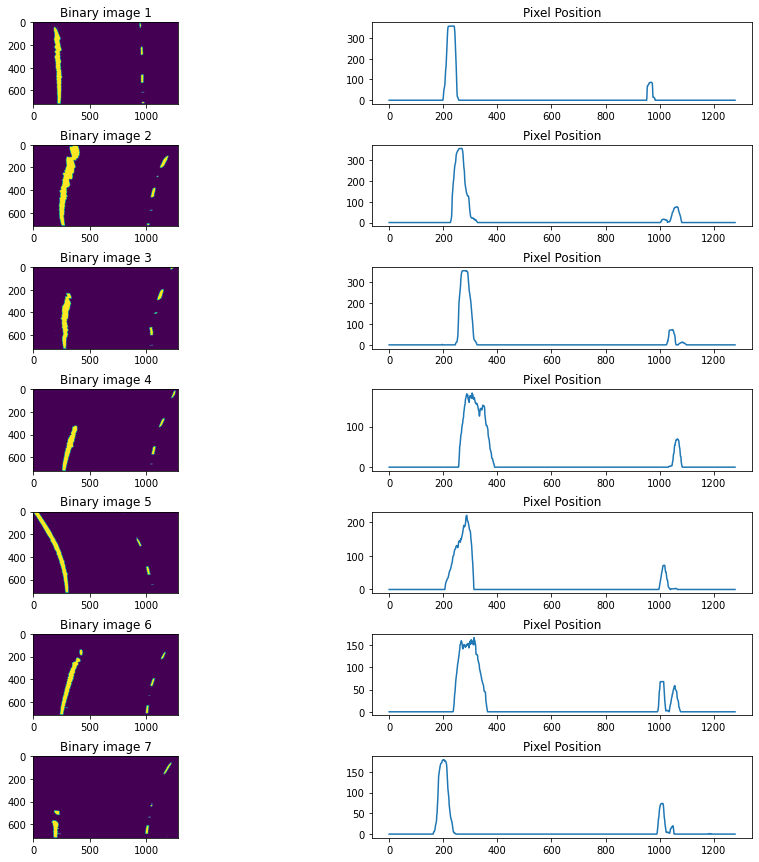

In [ ]:
f,axes= plt.subplots(len( Processed_Image),2, figsize=(15,15))
f.subplots_adjust(hspace =0.5)
row=0

for image in Processed_Image:
    
    axes[row,0].imshow(image)
    axes[row,0].set_title('Binary image '+str(row+1))
    

    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    axes[row,1].plot(histogram)
    axes[row,1].set_title('Pixel Position')  
    
    row+=1

# sliding window search and fitting the curve with green line

In [ ]:
fit_prev_left=[]
fit_prev_right=[]
fit_sum_left=0
fit_sum_right=0
def Plot_line(combinedImage, smoothen=False,prevFrameCount=6 ):  
    histogram =get_hist(combinedImage)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((combinedImage, combinedImage, combinedImage))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int64(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    lane_width= abs(rightx_base-leftx_base)
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int64(combinedImage.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = combinedImage.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = combinedImage.shape[0] - (window+1)*window_height
        win_y_high = combinedImage.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int64(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int64(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if(smoothen):
        global fit_prev_left
        global fit_prev_right
        global fit_sum_left
        global fit_sum_right
        if(len(fit_prev_left)>prevFrameCount):
            fit_sum_left-= fit_prev_left.pop(0)
            fit_sum_right-= fit_prev_right.pop(0)

        fit_prev_left.append(left_fit)
        fit_prev_right.append(right_fit)
        fit_sum_left+=left_fit
        fit_sum_right+= right_fit

        no_of_fit_values=len(fit_prev_left) 
        left_fit= fit_sum_left/no_of_fit_values
        right_fit= fit_sum_right/no_of_fit_values
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, combinedImage.shape[0]-1, combinedImage.shape[0] )

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    nonzero = combinedImage.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    window_img = np.zeros_like(out_img)
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int64([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int64([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return out_img, result, left_fitx,right_fitx,ploty,left_fit, right_fit,left_lane_inds,right_lane_inds,lane_width


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

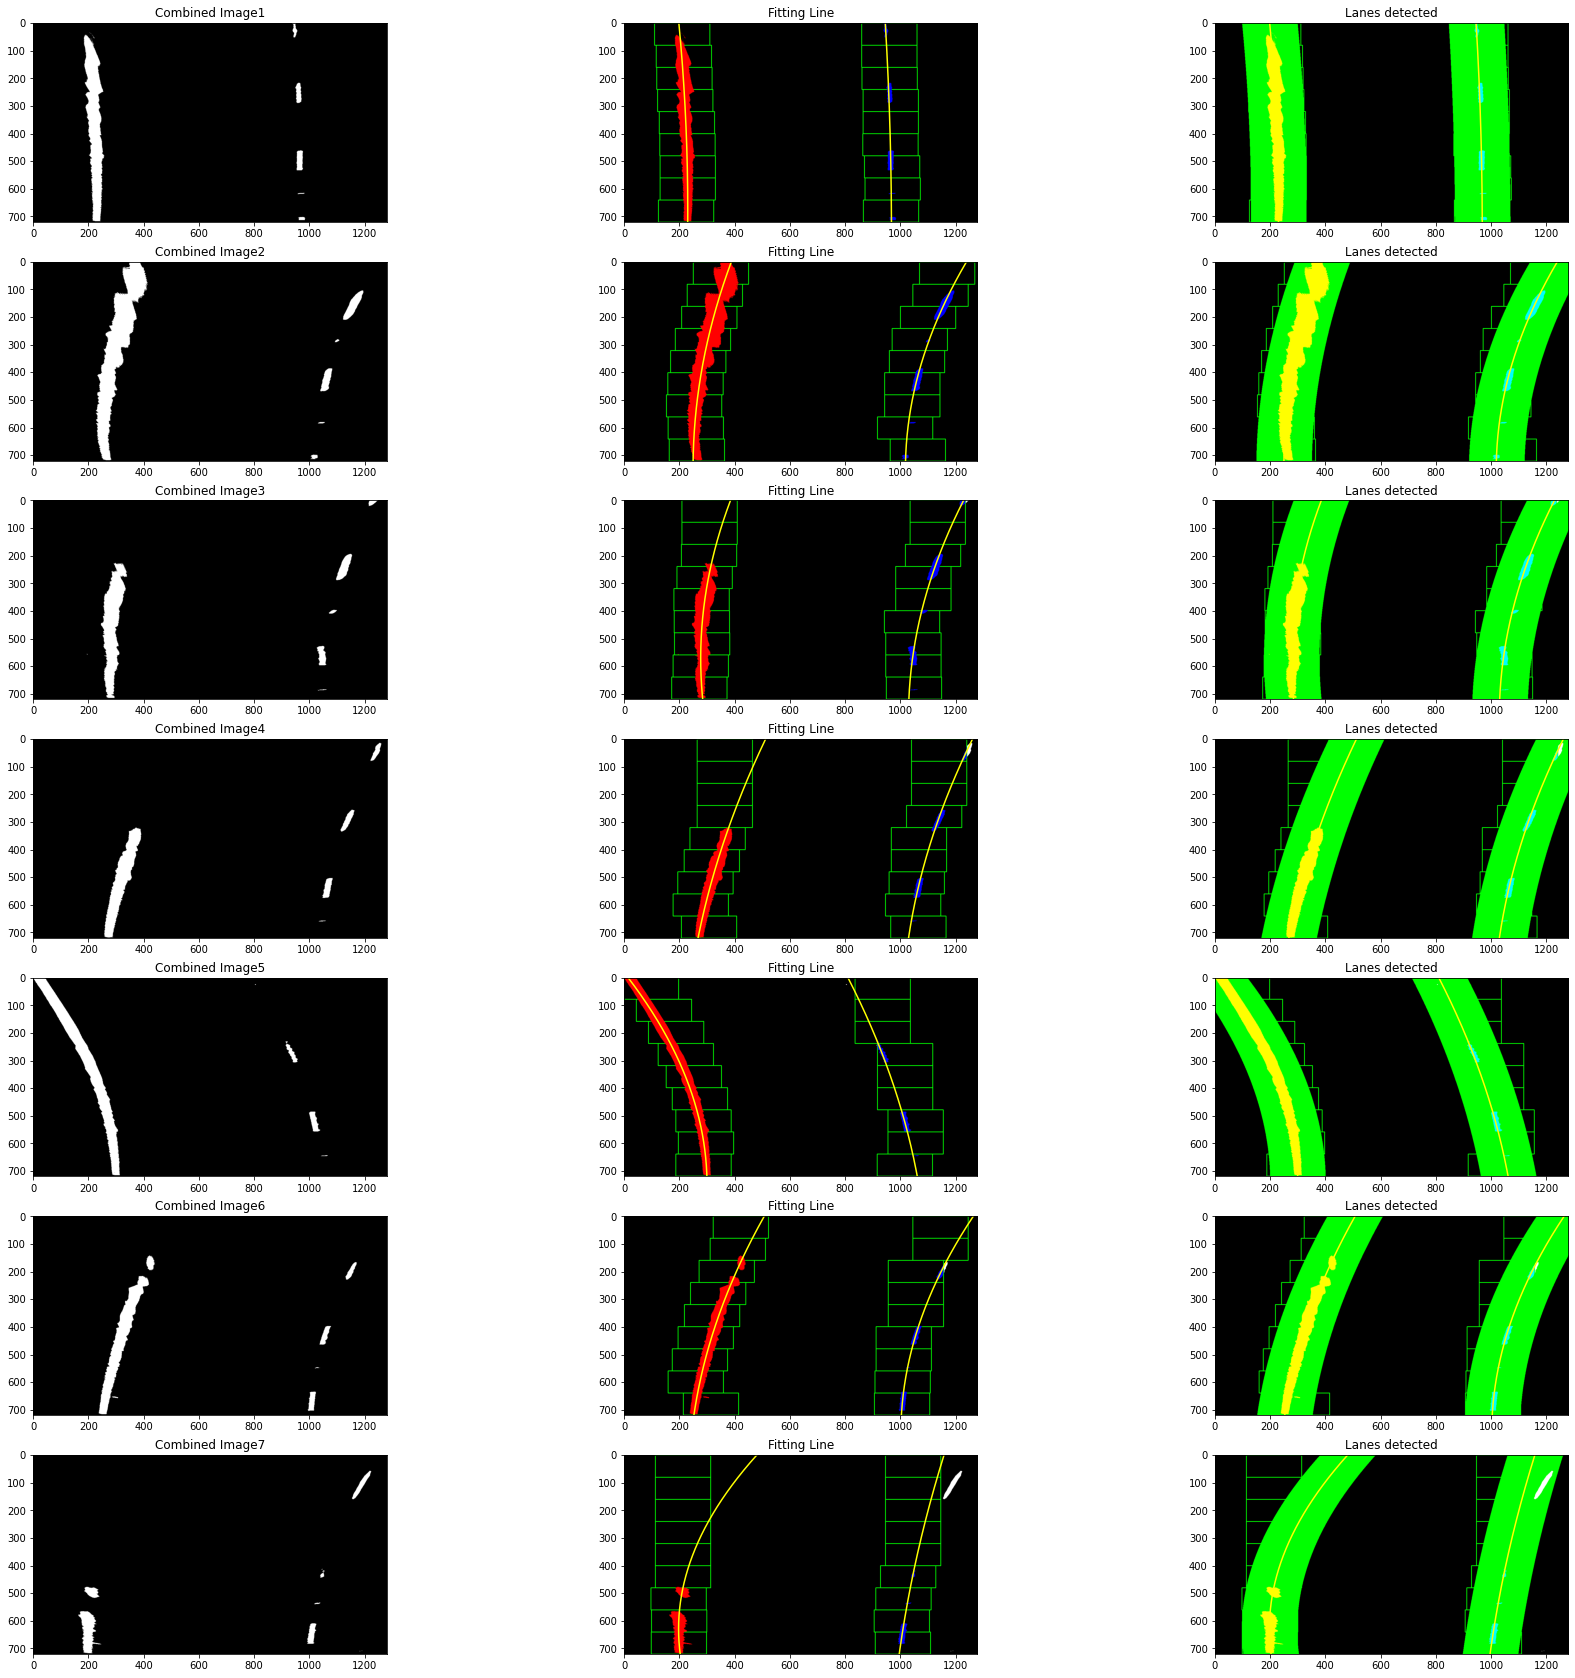

In [ ]:
f,axes= plt.subplots(len(Unwarped_images),3, figsize=(30,30))
f.subplots_adjust(hspace =0.2, wspace=0.2)
row=0

for image in Processed_Image:
    global fit_prev_left
    global fit_prev_right
    global fit_sum_left
    global fit_sum_right
    fit_prev_left=[]
    fit_prev_right=[]
    fit_sum_left=0
    fit_sum_right=0
    axes[row,0].imshow(image,cmap='gray')
    axes[row,0].set_title('Combined Image'+str(row+1))
    

    out_img,out_img1, left_fitx,right_fitx,ploty,left_fit, right_fit,left_lane_inds,right_lane_inds,lane_width= Plot_line(image)
    axes[row,1].imshow(out_img)
    axes[row,1].plot(left_fitx, ploty, color='yellow')
    axes[row,1].plot(right_fitx, ploty, color='yellow')
    axes[row,1].set_title('Fitting Line')
    
    axes[row,2].imshow(out_img1)
    axes[row,2].plot(left_fitx, ploty, color='yellow')
    axes[row,2].plot(right_fitx, ploty, color='yellow')
    axes[row,2].set_title("Lanes detected")
    
    row+=1

# Drawing the center green Lane

In [ ]:

#Step 1: Define the endpoints(fit_left, fit_right).
#Step 2: Define the image using zeros.
#Step 3: Draw the polygon using the fillpoly(img,pts,colors) function.

def draw_lane(test_images,combinedImage, left_fitx, right_fitx, M):
    new_img = np.copy(test_images)

    warp_zero = np.zeros_like(combinedImage).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = combinedImage.shape
    #Give start and the end point and it will return a sequence in that interval
    # Generate x and y values for plotting
    ploty = np.linspace(0, h-1, num=h)

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int64([pts]), (0,255, 0))
    #Outlines of the lane is red
    cv2.polylines(color_warp, np.int64([pts_left]), isClosed=False, color=(255,0,0), thickness=15)
    cv2.polylines(color_warp, np.int64([pts_right]), isClosed=False, color=(255,0,0), thickness=15)

    #Color_warp is modified 
    return color_warp, new_img

# For testing the image reversing with drawn lane

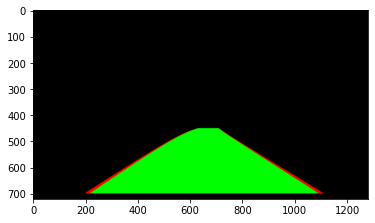

In [ ]:
inv,M=PerspectiveTransform(src,dst)
color_warp, new_img=draw_lane(test_images[1],Processed_Image[1],left_fitx, right_fitx, M)
rev=reverse_warping(color_warp,inv)
plt.imshow(rev)

# Caclulating the distance of car from center

In [ ]:
#Get the center of the lane and the car
#Get the difference
#Apply that on many frame to get the average
center_distances= Queue(maxsize=15)
distanceSum=0
def get_car_position(l_fit, r_fit,w,h):
    #convert from pixel space to meter space

    xm_per_pix=3.7/720
    center_dist=0
    lane_center_position=0 
    if r_fit is not None and l_fit is not None:
        #Center of the car
        #w = the width of the car as the camera is inside the car
        car_position = w/2
        #Get the center of lane
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        #distance from the center
        center_dist = (car_position - lane_center_position) * xm_per_pix
    
    global distanceSum           
    if(center_distances.full()):
        el=center_distances.get()
        distanceSum-=el
    
    center_distances.put(center_dist)
    distanceSum+=center_dist
    
    no_of_distance_values=center_distances.qsize() 
    #the average center_distance
    center_dist= distanceSum/no_of_distance_values
    return center_dist,lane_center_position

# Caclulating the direction of car from center

In [ ]:
def get_direction(center_dist):
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    return direction

# Calculating Radius of curvature

In [ ]:
width_lane_avg=[]
radius_values = Queue(maxsize=15)
radius_sum=0
#bgeb area of the lane w mn l area b3ml l circle w ageb l radius
def calc_radius_position(combined, l_fit, r_fit, l_lane_inds, r_lane_inds):
    
    # Define conversions in x and y from pixels space to meters

    ym_per_pix =30/720 # meters per pixel in y dimension
    xm_per_pix =3.7/720 # meters per pixel in x dimension

    left_curverad, right_curverad, center_dist = ( 0, 0, 0)
    h = combined.shape[0]
    w = combined.shape[1]
    ploty = np.linspace(0, h-1, h)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    #get the indices of non-zero element first array of the transposed array and the second of original array
    nonzero = combined.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #now we have the position of white pixels in y_axis and x_axis
    #Next step we wanna separate into left and right through the indices of the lane
    
    # Extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
        #applying the formula for radius calculation
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
    
    # Averaging radius value over past 15 frames
    global radius_sum           
    if(radius_values.full()):
        el=radius_values.get()
        radius_sum-=el
        
    curve_radius= (left_curverad+right_curverad)/2
    radius_values.put(curve_radius)
    radius_sum+=curve_radius
    
    no_of_radius_values=radius_values.qsize() 
    curve_radius= radius_sum/no_of_radius_values
    
    center_dist,lane_center_position= get_car_position(l_fit,r_fit,w,h) #getting the car distance from the center
    return curve_radius, center_dist,lane_center_position

# Plotting details on the Image

In [ ]:
def Plot_details(laneImage,curv_rad,center_dist,lane_center_position):
    offest_top=0
    copy= np.zeros_like(laneImage)
    
    h = laneImage.shape[0]
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    #cv2.putText(image, text, org, font, fontScale, color[, thickness[, lineType[,]]])
    cv2.putText(laneImage, text, (40,70+offest_top), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(copy, text, (40,100+offest_top), font, 4.0, (255,255,255), 3, cv2.LINE_AA)
    
    abs_center_dist = abs(center_dist)
    direction= get_direction(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
#     cv2.putText(laneImage, 'steering '+direction, (40,110+offest_top), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(laneImage, '|', (640,710), font, 2.0, (255,255,255), 3, cv2.LINE_AA)
    cv2.putText(laneImage, '|', (int(lane_center_position),680), font, 2.0, (255,0,0), 3, cv2.LINE_AA)
    cv2.putText(laneImage, text, (40,120+offest_top), font, 1.5, (255,255,255), 2, cv2.LINE_AA)

    
    return laneImage, copy

# Pipeline

In [ ]:
def Lane_pipeline(img,smoothen,prevFrameCount):
    undistorted_image= undistort(img)
    M, minv = PerspectiveTransform(src,dst)
    warped_image = WarpImg(undistorted_image,M)
    h,l,image_S_channel = CVt2hls(warped_image)
    
    imgY, imgCr, imgb, imgS= Custom_channel_converter(warped_image)
    
    Ybinary= channelwise_thresholding(imgY,(215,255))
    Crbinary= channelwise_thresholding(imgCr,(215,255))
    Lbinary= channelwise_thresholding(imgb,(215,255))
    Sbinary= channelwise_thresholding(imgS,(200,255))
    combined = np.zeros_like(imgY)
    
    sobel_image1= sobel_image(image_S_channel,'x', 15,60, False)
    sobel_grad_image= sobel_gradient_image(image_S_channel,  (0.5,1.8), False)
    combined[(Crbinary==1)|(Ybinary==1)|((Lbinary==1)&(Sbinary==1))] = 1

    out_img,out_img1, left_fitx,right_fitx,ploty,left_fit, right_fit,left_lane_inds,right_lane_inds,lane_width= Plot_line(combined,smoothen,prevFrameCount)
    curverad,center_dist,lane_center_position= calc_radius_position(combined,left_fit, right_fit,left_lane_inds,right_lane_inds)
    laneImage,new_img =draw_lane(img, combined, left_fitx, right_fitx, M)
    unwarped_image= reverse_warping(laneImage,M)
    #For Adding images
    laneImage = cv2.addWeighted(new_img, 1, unwarped_image, 0.5, 0)
    laneImage, copy = Plot_details(laneImage,curverad,center_dist,lane_center_position)
    return img,out_img,out_img1,unwarped_image,laneImage,combined,copy


# Test Pipeline on test_image

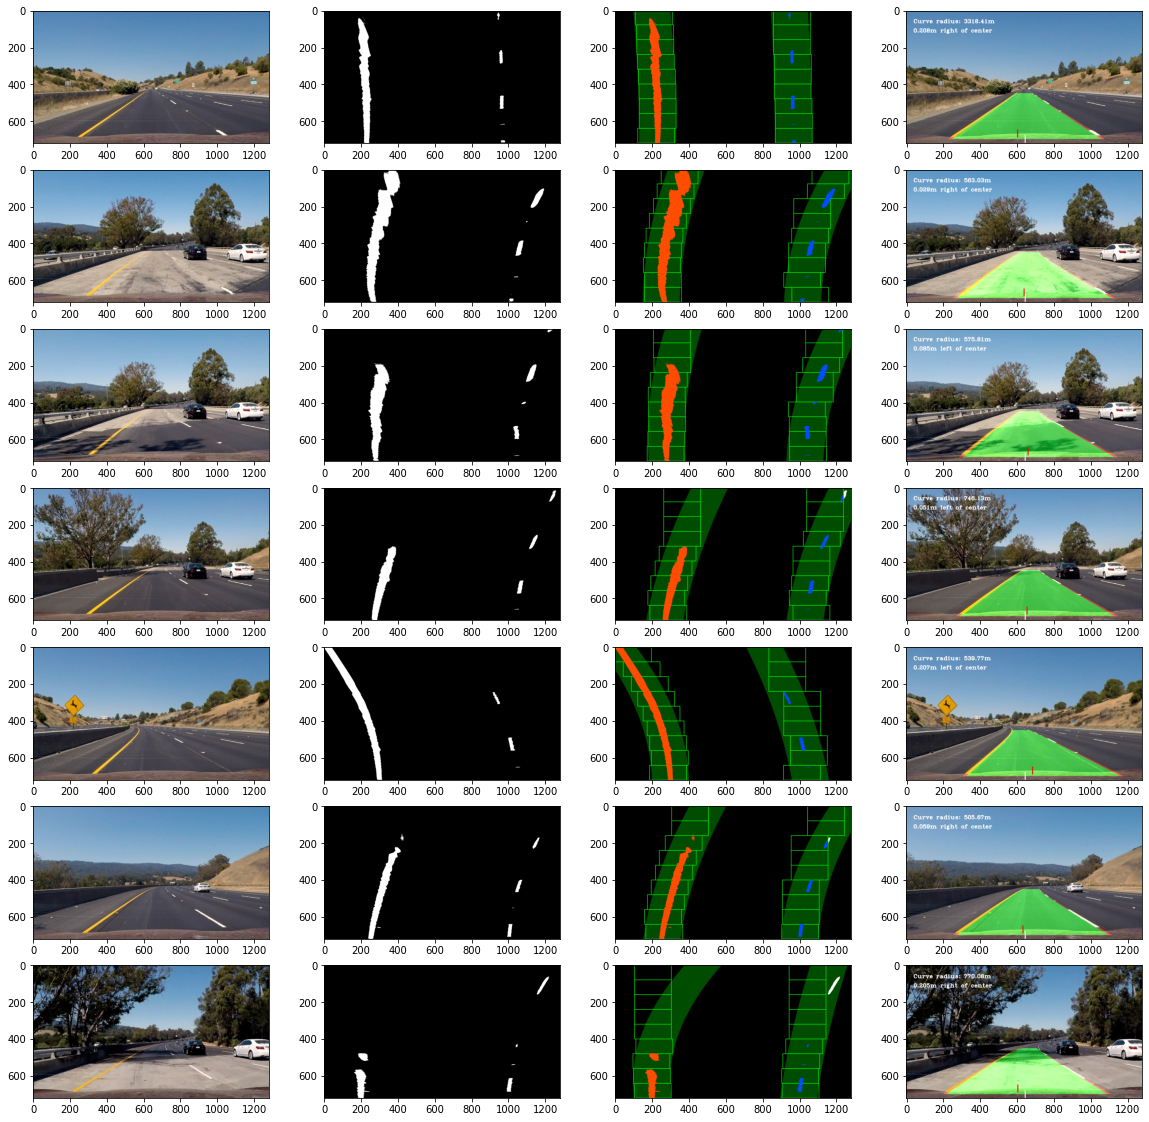

In [ ]:
f,axes= plt.subplots(7,4, figsize=(20,20))
row=0

for index in range(7):
    global fit_prev_left
    global fit_prev_right
    global fit_sum_left
    global fit_sum_right
    global radius_sum
    global radius_values
    global center_distances
    global distanceSum
    fit_prev_left=[]
    fit_prev_right=[]
    fit_sum_left=0
    fit_sum_right=0
    radius_sum=0
    radius_values.queue.clear()
    center_distances.queue.clear()
    distanceSum=0
    
    image= test_images[index]

    rgb_image,out_img,out_img1,unwarped_image,laneImage,combined,copy= Lane_pipeline(image, False,0)
    
    axes[row,0].imshow(rgb_image)
    axes[row,1].imshow(combined, cmap='gray')
    axes[row,2].imshow(out_img1)
    axes[row,3].imshow(laneImage)
    row+=1

# Video Creation

In [ ]:
def CallPipeline(image):
    smoothen= True
    prevFrameCount=4
    rgb_image,out_img,out_img1,unwarped_image,laneImage,combined,data_copy= Lane_pipeline(image,smoothen,prevFrameCount)

    out_image = np.zeros((720,1280,3), dtype=np.uint8)
    
    #stacking up various images in one output Image
    out_image[0:720,0:1280,:] = cv2.resize(laneImage,(1280,720)) #top-left
    out_image[20:190,960:1260,:] = cv2.resize(np.dstack((combined*255, combined*255, combined*255)),(300,170))#side Panel
    out_image[210:380,960:1260,:] = cv2.resize(out_img,(300,170))#side Panel
    out_image[400:570,960:1260,:] = cv2.resize(data_copy,(300,170))#bottom-left
    return out_image

## Project Video

In [ ]:

video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(20,25)
processed_video = video_input1.fl_image(CallPipeline)
%time processed_video.write_videofile(video_output1, audio=False)
video_input1.reader.close()
video_input1.audio.reader.close_proc()

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [07:20<00:00,  2.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 7min 19s, sys: 9.02 s, total: 7min 28s
Wall time: 7min 22s


## Challenge Video

In [ ]:
video_output1 = 'challenge_video_output.mp4'
video_input1 = VideoFileClip('challenge_video.mp4')#.subclip(20,25)
processed_video = video_input1.fl_image(CallPipeline)
%time processed_video.write_videofile(video_output1, audio=False)
video_input1.reader.close()
video_input1.audio.reader.close_proc()

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [02:46<00:00,  2.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 2min 52s, sys: 3.59 s, total: 2min 55s
Wall time: 2min 49s
